# Imports

In [1]:
import numpy as np
import pandas as pd
import io
import bson                 
import matplotlib.pyplot as plt
import multiprocessing as mp 
from PIL import Image
from time import time
import math
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
import bcolz
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import AveragePooling2D
import keras

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1050 Ti (CNMeM is disabled, cuDNN 5103)


# Observations

Forum:
1. All images are 180 - 180
2. One guy got 68% by finetuning for 6 epochs resnet50 (only last conv block is trainable)
3. Same guy as above said that random cropping images from 180 180 to 160 160 and averaging got him 68% instead of 6435

Notebook: https://www.kaggle.com/bguberfain/naive-statistics
1. there more products with one image then with more pictures combined
2. There around 1m pictures with 4 and 2 images, and only half million with 3 images
3. Some level3 categories have only 12 examples (but not less)
4. Cummulative counts of categories descending by number of products 


* 0.20	26
* 0.40	80
* 0.60	221
* 0.80	688
* 0.90	1334
* 0.95	2073
* 0.98	3040
* 0.99	3663
* 1.00	5270

Notebook: https://www.kaggle.com/vfdev5/data-visualization-and-analysis
1. From the look of rare categories it will be impossible to predict them by 12 images only
2. Only 175 categories have more then 8000 products
3. Around 1000 categories have more then 1000 products
4. Around 2000 categories have more then 200 products
5. Around 2000 categories seem to have less then 100 products

# Read sample

In [2]:
data = bson.decode_file_iter(open('../data/raw/train_example.bson', 'rb'))

prod_to_category = dict()
imgs = []

for c, d in enumerate(data):
    product_id = d['_id']
    category_id = d['category_id'] # This won't be in Test data
    prod_to_category[product_id] = category_id
    for e, pic in enumerate(d['imgs']):
        img = Image.open(io.BytesIO(pic['picture']))
        img.save('../data/interim/train_example/imgs/{}.jpg'.format(product_id))
        imgs.append(img)
        
prod_to_category = pd.DataFrame.from_dict(prod_to_category, orient='index')
prod_to_category.index.name = '_id'
prod_to_category.rename(columns={0: 'category_id'}, inplace=True)

In [3]:
prod_to_category[:5]

,category_id
_id,
0,1000010653
1,1000010653
2,1000004079
3,1000004141
4,1000015539


In [4]:
{img.size[0] + img.size[1] for img in imgs}

{360}

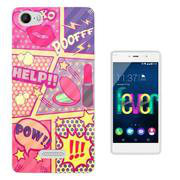

In [5]:
imgs[10]

# Counting categories

## Assumble product to category map

In [63]:
NCORE =  4

prod_to_category = mp.Manager().dict() # note the difference

def process(q, iolock):
    while True:
        d = q.get()
        if d is None:
            break
        product_id = d['_id']
        category_id = d['category_id']
        prod_to_category[product_id] = category_id
    
q = mp.Queue(maxsize=NCORE)
iolock = mp.Lock()
pool = mp.Pool(NCORE, initializer=process, initargs=(q, iolock))

# process the file
start_time = time()

data = bson.decode_file_iter(open('/home/nighturs/Media/share/datasets/kaggle-cdiscount/train.bson', 'rb'))
for c, d in enumerate(data):  
    q.put(d)  # blocks until q below its max size
    if c % 100000 == 99999:
        print('{} - Read {} entries'.format(math.floor(time() - start_time), c + 1))
        
# tell workers we're done

for _ in range(NCORE):  
    q.put(None)
pool.close()
pool.join()

# convert back to normal dictionary
prod_to_category = dict(prod_to_category)
prod_to_category = pd.DataFrame.from_dict(prod_to_category, orient='index')
prod_to_category.index.name = '_id'
prod_to_category.rename(columns={0: 'category_id'}, inplace=True)

8 - Read 100000 entries
16 - Read 200000 entries
24 - Read 300000 entries
32 - Read 400000 entries
40 - Read 500000 entries
49 - Read 600000 entries
57 - Read 700000 entries
66 - Read 800000 entries
75 - Read 900000 entries
83 - Read 1000000 entries
92 - Read 1100000 entries
100 - Read 1200000 entries
109 - Read 1300000 entries
117 - Read 1400000 entries
126 - Read 1500000 entries
135 - Read 1600000 entries
143 - Read 1700000 entries
152 - Read 1800000 entries
160 - Read 1900000 entries
169 - Read 2000000 entries
177 - Read 2100000 entries
186 - Read 2200000 entries
195 - Read 2300000 entries
203 - Read 2400000 entries
212 - Read 2500000 entries
221 - Read 2600000 entries
229 - Read 2700000 entries
238 - Read 2800000 entries
246 - Read 2900000 entries
255 - Read 3000000 entries
264 - Read 3100000 entries
272 - Read 3200000 entries
281 - Read 3300000 entries
289 - Read 3400000 entries
298 - Read 3500000 entries
307 - Read 3600000 entries
315 - Read 3700000 entries
324 - Read 3800000 ent

In [65]:
prod_to_category.to_csv('../data/interim/prod_to_category.csv')

In [2]:
prod_to_category = pd.read_csv('../data/interim/prod_to_category.csv', index_col='_id')

/home/nighturs/.local/share/virtualenvs/kaggle-cdiscount-image-classification-nx22QNl0/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Create sample

In [3]:
category_stats = prod_to_category.groupby(by='category_id').size()
category_stats.sort_values(ascending=False, inplace=True)
category_stats.head()

category_id
1000018296    79640
1000011423    71116
1000011427    69784
1000014202    65642
1000015309    65435
dtype: int64

In [4]:
category_stats[:2000].tail()

category_id
1000014934    347
1000016744    346
1000014024    346
1000011405    346
1000017790    345
dtype: int64

In [5]:
categories  = category_stats[:2000].index.values
categories_set = set(categories)
categories

array([1000018296, 1000011423, 1000011427, ..., 1000014024, 1000011405,
       1000017790])

In [12]:
np.random.seed(123)

sample = np.array([], dtype=np.int64)
for category, prods in prod_to_category.groupby(by='category_id'):
    if not category in categories_set:
        continue
    sample = np.concatenate((sample, np.random.choice(prods.index.values, 
                                            size=(100 if prods.shape[0] >= 100 else prods.shape[0]), 
                                            replace=False)))

In [19]:
sample_set = set(sample)
sample.size

200000

In [18]:
idx = np.arange(sample.size)
np.random.seed(123)
np.random.shuffle(idx)
cut = int(sample.size * 0.8)
sample_train = sample[idx[:cut]]
sample_test = sample[idx[cut:]]
len(sample_train), len(sample_test)

(160000, 40000)

In [21]:
NCORE =  4

def process(q, iolock):
    while True:
        d = q.get()
        if d is None:
            break
        product_id = d['_id']
        if product_id in sample_set:
            picture = Image.open(io.BytesIO(d['imgs'][0]['picture']))
            picture.save('../data/interim/big_sample/imgs/{}.jpg'.format(product_id))
        
    
q = mp.Queue(maxsize=NCORE)
iolock = mp.Lock()
pool = mp.Pool(NCORE, initializer=process, initargs=(q, iolock))

# process the file
start_time = time()

data = bson.decode_file_iter(open('/home/nighturs/Media/share/datasets/kaggle-cdiscount/train.bson', 'rb'))
for c, d in enumerate(data):  
    q.put(d)  # blocks until q below its max size
    if c % 100000 == 99999:
        print('{} - Read {} entries'.format(math.floor(time() - start_time), c + 1))
        
# tell workers we're done

for _ in range(NCORE):  
    q.put(None)
pool.close()
pool.join()

8 - Read 100000 entries
18 - Read 200000 entries
29 - Read 300000 entries
39 - Read 400000 entries
50 - Read 500000 entries
61 - Read 600000 entries
72 - Read 700000 entries
84 - Read 800000 entries
95 - Read 900000 entries
107 - Read 1000000 entries
119 - Read 1100000 entries
131 - Read 1200000 entries
143 - Read 1300000 entries
154 - Read 1400000 entries
167 - Read 1500000 entries
179 - Read 1600000 entries
191 - Read 1700000 entries
203 - Read 1800000 entries
215 - Read 1900000 entries
226 - Read 2000000 entries
237 - Read 2100000 entries
249 - Read 2200000 entries
260 - Read 2300000 entries
271 - Read 2400000 entries
282 - Read 2500000 entries
294 - Read 2600000 entries
305 - Read 2700000 entries
317 - Read 2800000 entries
328 - Read 2900000 entries
339 - Read 3000000 entries
347 - Read 3100000 entries
355 - Read 3200000 entries
364 - Read 3300000 entries
372 - Read 3400000 entries
380 - Read 3500000 entries
389 - Read 3600000 entries
397 - Read 3700000 entries
405 - Read 3800000 e

# Precompute VGG16 Conv layers for sample images

In [2]:
vgg_model = VGG16(include_top=False, input_shape=(3, 180, 180))

In [2]:
def save_array(fname, arr): 
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
    
def load_array(fname): 
    return bcolz.open(fname)[:]

backup = []
def save_vgg16_vecs(vec_fname, img_name_fname, folder):
    gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    batches = gen.flow_from_directory(folder, 
                                      target_size=(180, 180), 
                                      batch_size=220, 
                                      class_mode=None,
                                      shuffle=False)
    x = AveragePooling2D()(vgg_model.output)
    model = Model(vgg_model.input, x)
    vecs = model.predict_generator(batches, steps=(batches.samples + batches.batch_size) 
                                          // batches.batch_size, verbose=1)
    backup.append(vecs)
    save_array(vec_fname, vecs)
    save_array(img_name_fname, batches.filenames)
    
def load_vgg16_vecs(vec_fname, img_name_fname):
    return load_array(img_name_fname), load_array(vec_fname)

In [4]:
save_vgg16_vecs('../data/interim/big_sample_vgg16_vecs', 
                '../data/interim/big_sample_vgg16_img_name', 
                '../data/interim/big_sample')

Found 200000 images belonging to 1 classes.
910/910 [==============================] - 3915s  


# ResNet50

In [3]:
resnet_model = ResNet50(include_top=False, input_shape=(3, 197, 197))

In [4]:
backup = []
def save_resnet50_vecs(vec_fname, img_name_fname, folder):
    gen = ImageDataGenerator(preprocessing_function=keras.applications.resnet50.preprocess_input)
    batches = gen.flow_from_directory(folder, 
                                      target_size=(197, 197), 
                                      batch_size=220, 
                                      class_mode=None,
                                      shuffle=False)
    vecs = resnet_model.predict_generator(batches, steps=(batches.samples + batches.batch_size) 
                                          // batches.batch_size, verbose=1)
    backup.append(vecs)
    save_array(vec_fname, vecs)
    save_array(img_name_fname, batches.filenames)
    
def load_resnet50_vecs(vec_fname, img_name_fname):
    return load_array(img_name_fname), load_array(vec_fname)

In [5]:
save_resnet50_vecs('../data/interim/big_sample_resnet50_vecs', 
                   '../data/interim/big_sample_resnet50_img_name', 
                   '../data/interim/big_sample')

Found 200000 images belonging to 1 classes.
910/910 [==============================] - 2752s  
